In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
import seaborn as sns
import matplotlib.pyplot as plt

password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''
with client_summary as (
select
        account_id,
        avg(amount) as avg_trans_amount,
        count(trans_id) as trans_count,
        avg(balance) as avg_balance
    from trans
    group by 1
)

select 
    c.client_id,
    left(c.birth_number, 2) as age,
    c.district_id,
    a.frequency,
    convert(a.date,date) as account_start_date,
    convert(left(cd.issued,6),date) as card_issued_date,
    convert(l.date,date) as loan_start_date,
    datediff(convert(l.date,date),convert(a.date,date)) as days_between,
    cs.avg_trans_amount,
    cs.avg_balance,
    cs.trans_count,
    cd.type as card_type,
    l.amount as loan_amount,
    l.duration as loan_duration,
    l.payments as loan_payments,
    l.status as loan_status
from client c
join disp d on c.client_id = d.client_id
join account a on d.account_id = a.account_id
join loan l on l.account_id = a.account_id
left join card cd on cd.disp_id = d.disp_id
join client_summary cs on cs.account_id = a.account_id'''

data = pd.read_sql_query(query, engine)
data.head()

,client_id,age,district_id,frequency,account_start_date,card_issued_date,loan_start_date,days_between,avg_trans_amount,avg_balance,trans_count,card_type,loan_amount,loan_duration,loan_payments,loan_status
0,2,45,1,POPLATEK MESICNE,1993-02-26,None,1994-01-05,313,5459.547324,36313.029626,374,None,80952,24,3373.0,A
1,3,40,1,POPLATEK MESICNE,1993-02-26,None,1994-01-05,313,5459.547324,36313.029626,374,None,80952,24,3373.0,A
2,25,39,21,POPLATEK MESICNE,1995-04-07,None,1996-04-29,388,4165.924709,15464.591870,259,None,30276,12,2523.0,B
3,31,62,68,POPLATEK MESICNE,1996-07-28,None,1997-12-08,498,11278.724888,55738.666866,225,None,30276,12,2523.0,A
4,45,52,20,POPLATEK MESICNE,1997-08-18,None,1998-10-14,422,7871.525263,37845.293508,95,None,318480,60,5308.0,D


In [3]:
# A: Contract finished, no problems. 
# B: Contract finished, loan not paid. 
# C: Running contract, okay so far. 
# D: Running contract, client in debt.

In [4]:
data['loan_status'].value_counts()

C    493
A    258
D     45
B     31
Name: loan_status, dtype: int64

In [5]:
data.shape

(827, 16)

In [6]:
data.dtypes

client_id               int64
age                    object
district_id             int64
frequency              object
account_start_date     object
card_issued_date       object
loan_start_date        object
days_between            int64
avg_trans_amount      float64
avg_balance           float64
trans_count             int64
card_type              object
loan_amount             int64
loan_duration           int64
loan_payments         float64
loan_status            object
dtype: object

In [7]:
data.isna().sum()

client_id               0
age                     0
district_id             0
frequency               0
account_start_date      0
card_issued_date      657
loan_start_date         0
days_between            0
avg_trans_amount        0
avg_balance             0
trans_count             0
card_type             657
loan_amount             0
loan_duration           0
loan_payments           0
loan_status             0
dtype: int64

In [8]:
data = data.drop(['card_issued_date','card_type'],axis=1)

In [9]:
data.dtypes

client_id               int64
age                    object
district_id             int64
frequency              object
account_start_date     object
loan_start_date        object
days_between            int64
avg_trans_amount      float64
avg_balance           float64
trans_count             int64
loan_amount             int64
loan_duration           int64
loan_payments         float64
loan_status            object
dtype: object

In [10]:
import datetime as dt

data['age'] = data['age'].astype('int')
data['account_start_date'] = pd.to_datetime(data['account_start_date'])
data['loan_start_date'] = pd.to_datetime(data['loan_start_date'])

data['account_start_date'] = data['account_start_date'].map(dt.datetime.toordinal)
data['loan_start_date'] = data['loan_start_date'].map(dt.datetime.toordinal)

data.head()

,client_id,age,district_id,frequency,account_start_date,loan_start_date,days_between,avg_trans_amount,avg_balance,trans_count,loan_amount,loan_duration,loan_payments,loan_status
0,2,45,1,POPLATEK MESICNE,727620,727933,313,5459.547324,36313.029626,374,80952,24,3373.0,A
1,3,40,1,POPLATEK MESICNE,727620,727933,313,5459.547324,36313.029626,374,80952,24,3373.0,A
2,25,39,21,POPLATEK MESICNE,728390,728778,388,4165.924709,15464.591870,259,30276,12,2523.0,B
3,31,62,68,POPLATEK MESICNE,728868,729366,498,11278.724888,55738.666866,225,30276,12,2523.0,A
4,45,52,20,POPLATEK MESICNE,729254,729676,422,7871.525263,37845.293508,95,318480,60,5308.0,D


In [11]:
data.dtypes

client_id               int64
age                     int32
district_id             int64
frequency              object
account_start_date      int64
loan_start_date         int64
days_between            int64
avg_trans_amount      float64
avg_balance           float64
trans_count             int64
loan_amount             int64
loan_duration           int64
loan_payments         float64
loan_status            object
dtype: object

In [12]:
data['district_id'] = data['district_id'].astype('object')
data = data.drop('client_id',axis=1)

In [13]:
data.dtypes

age                     int32
district_id            object
frequency              object
account_start_date      int64
loan_start_date         int64
days_between            int64
avg_trans_amount      float64
avg_balance           float64
trans_count             int64
loan_amount             int64
loan_duration           int64
loan_payments         float64
loan_status            object
dtype: object

In [14]:
data.isna().sum()

age                   0
district_id           0
frequency             0
account_start_date    0
loan_start_date       0
days_between          0
avg_trans_amount      0
avg_balance           0
trans_count           0
loan_amount           0
loan_duration         0
loan_payments         0
loan_status           0
dtype: int64

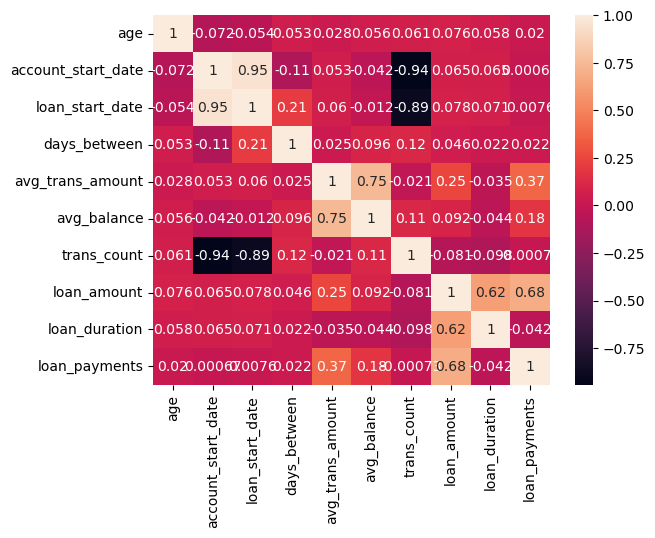

In [15]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [16]:
data = data.drop(['account_start_date','loan_start_date'],axis=1)

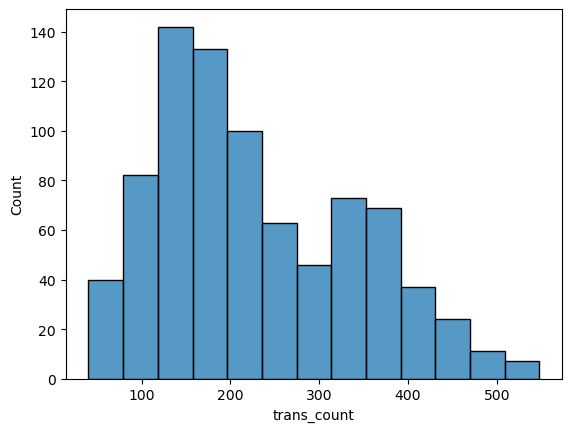

In [17]:
sns.histplot(data['trans_count'])
plt.show()

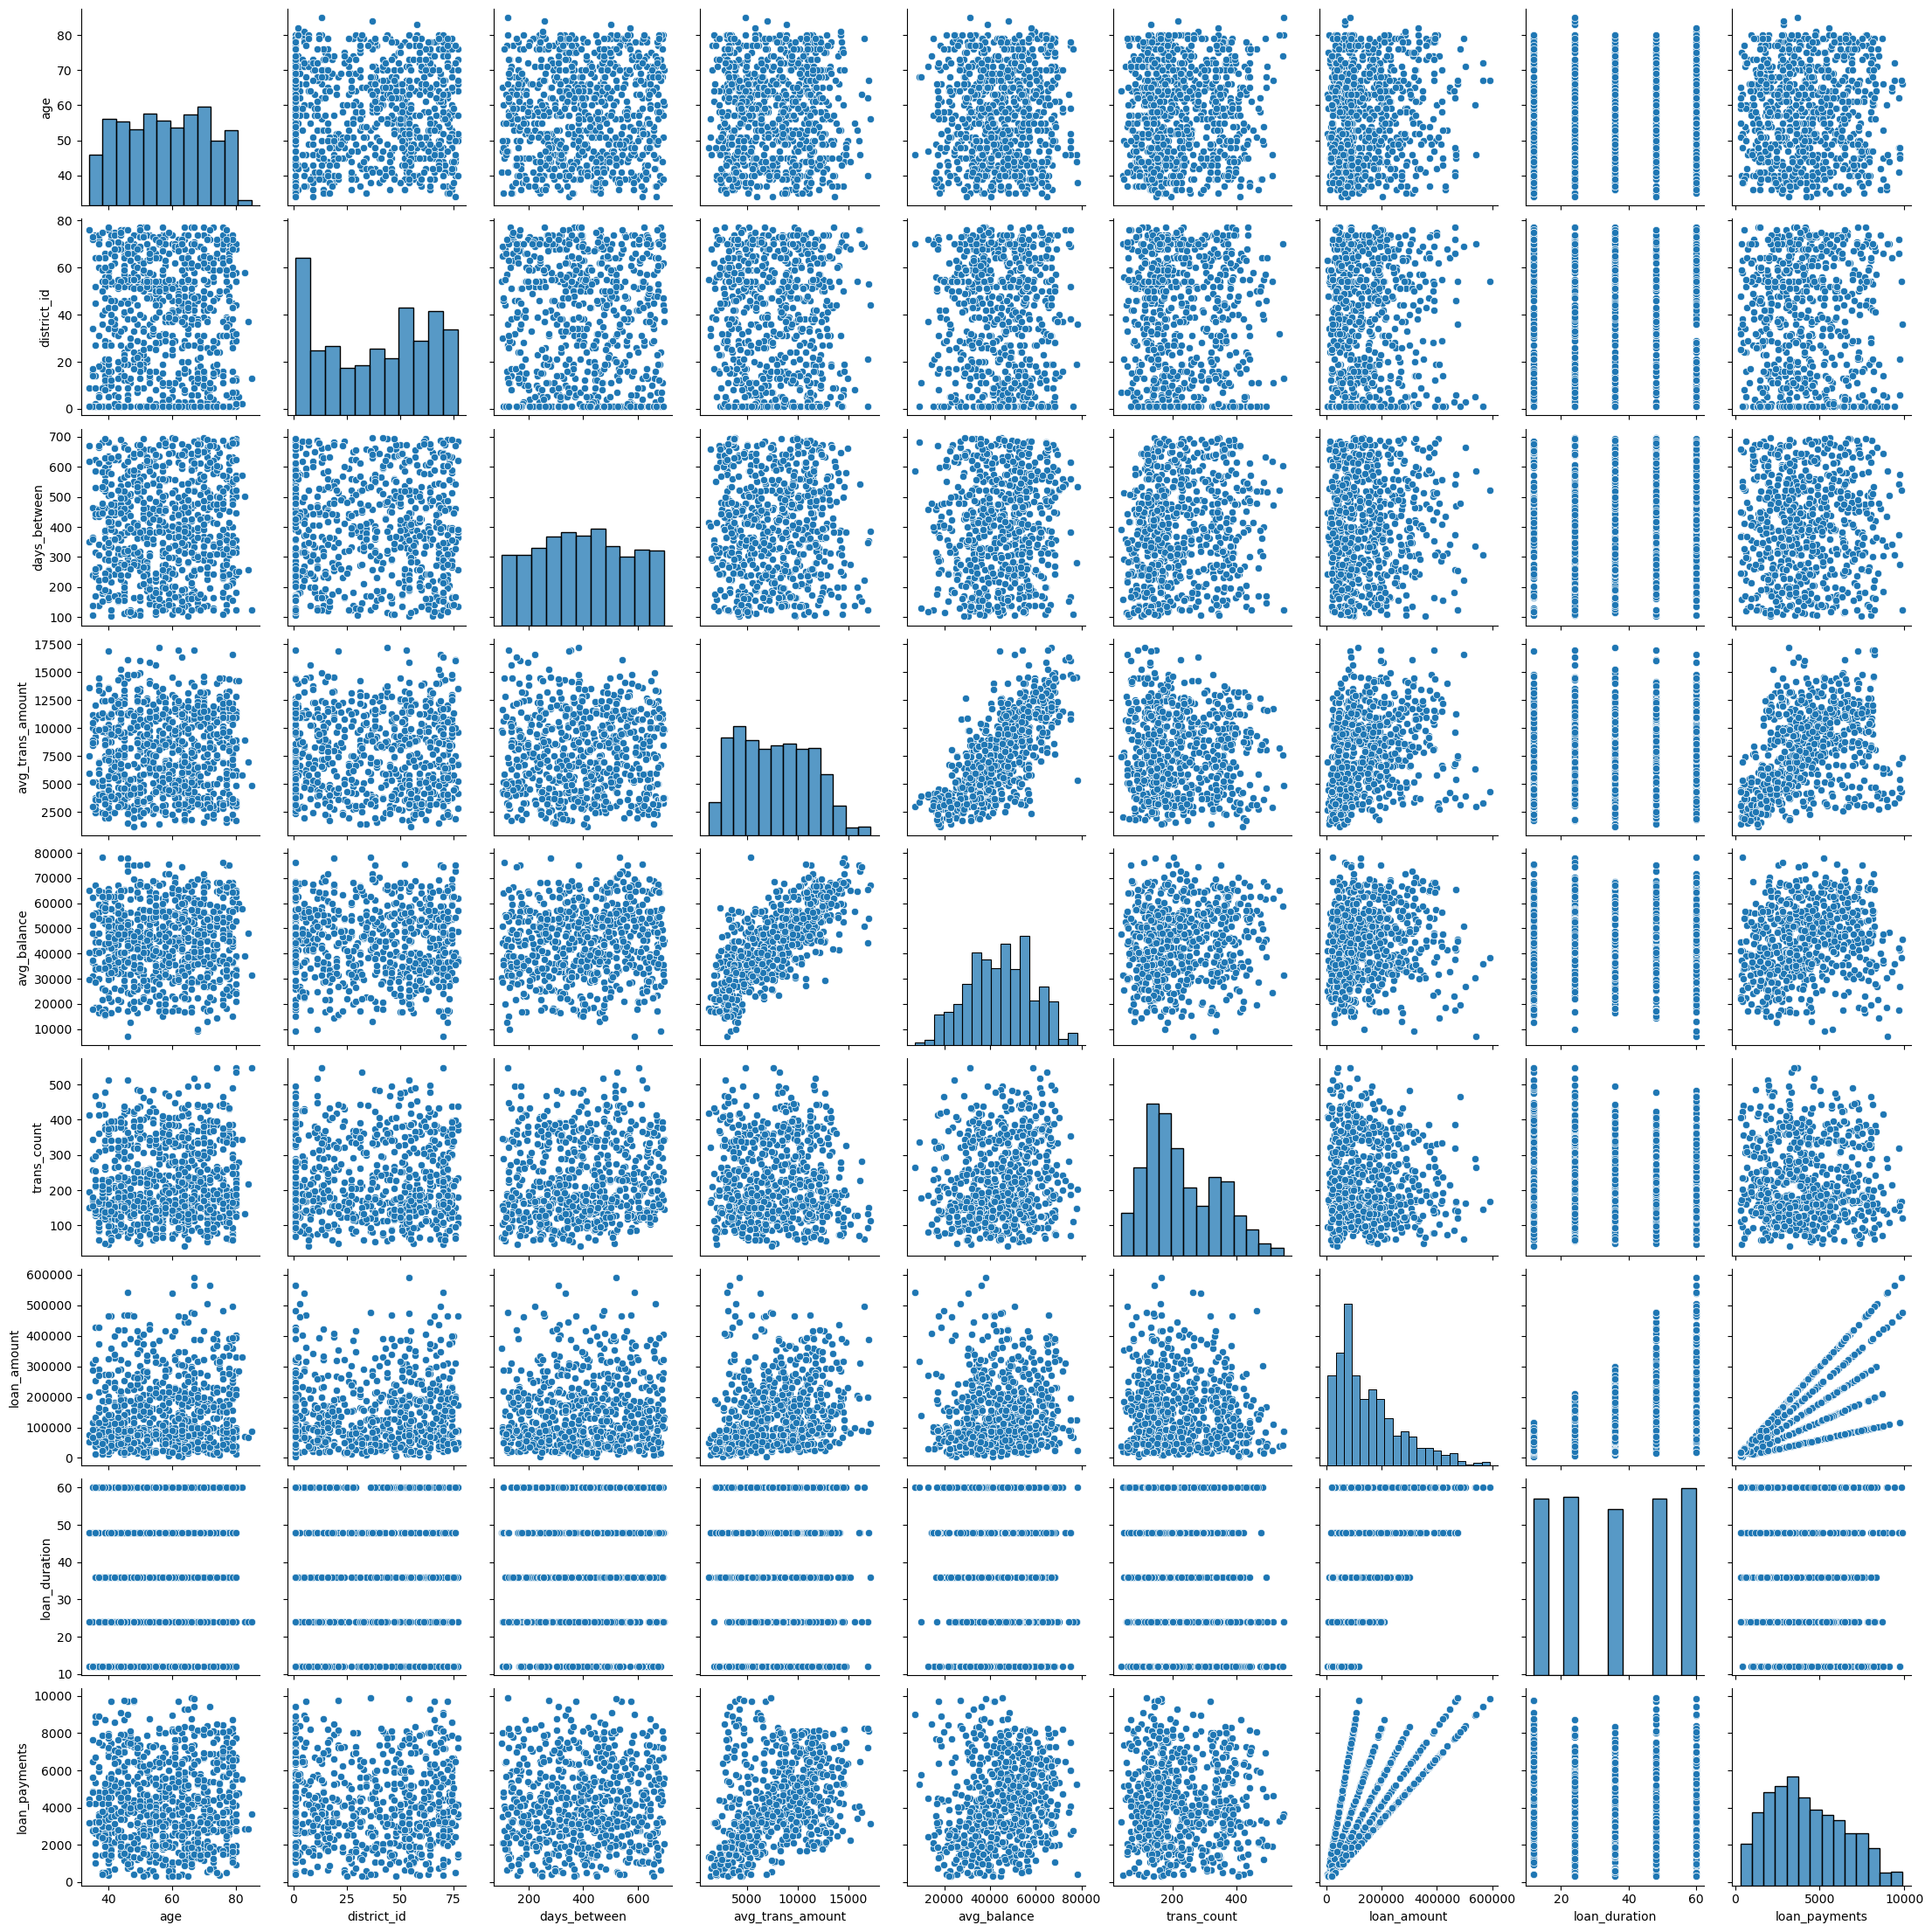

In [18]:
sns.pairplot(data)
plt.show()

In [19]:
import numpy as np
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include = np.number)
X.head()

,age,days_between,avg_trans_amount,avg_balance,trans_count,loan_amount,loan_duration,loan_payments
0,45,313,5459.547324,36313.029626,374,80952,24,3373.0
1,40,313,5459.547324,36313.029626,374,80952,24,3373.0
2,39,388,4165.924709,15464.591870,259,30276,12,2523.0
3,62,498,11278.724888,55738.666866,225,30276,12,2523.0
4,52,422,7871.525263,37845.293508,95,318480,60,5308.0


In [20]:
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns = X.columns
x.head()

,age,days_between,avg_trans_amount,avg_balance,trans_count,loan_amount,loan_duration,loan_payments
0,0.000506,0.003519,0.061373,0.408210,0.004204,0.910016,0.000270,0.037917
1,0.000450,0.003519,0.061373,0.408210,0.004204,0.910016,0.000270,0.037917
2,0.001135,0.011296,0.121289,0.450243,0.007541,0.881469,0.000349,0.073456
3,0.000962,0.007724,0.174926,0.864471,0.003490,0.469561,0.000186,0.039130
4,0.000162,0.001315,0.024532,0.117949,0.000296,0.992578,0.000187,0.016543


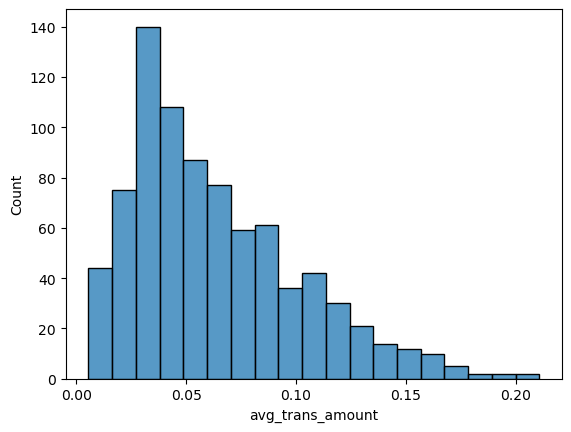

In [21]:
sns.histplot(x['avg_trans_amount'])
plt.show()

In [22]:
x

,age,days_between,avg_trans_amount,avg_balance,trans_count,loan_amount,loan_duration,loan_payments
0,0.000506,0.003519,0.061373,0.408210,0.004204,0.910016,0.000270,0.037917
1,0.000450,0.003519,0.061373,0.408210,0.004204,0.910016,0.000270,0.037917
2,0.001135,0.011296,0.121289,0.450243,0.007541,0.881469,0.000349,0.073456
3,0.000962,0.007724,0.174926,0.864471,0.003490,0.469561,0.000186,0.039130
4,0.000162,0.001315,0.024532,0.117949,0.000296,0.992578,0.000187,0.016543
...,...,...,...,...,...,...,...,...
822,0.000183,0.002181,0.030118,0.159448,0.000436,0.986607,0.000211,0.016443
823,0.000106,0.000369,0.028772,0.112855,0.000561,0.993057,0.000142,0.016551
824,0.000102,0.000369,0.028772,0.112855,0.000561,0.993057,0.000142,0.016551
825,0.001041,0.010333,0.099364,0.548859,0.004639,0.827044,0.000184,0.068920


In [23]:
cat = data.select_dtypes(include = object)
cat = cat.drop(['loan_status'],axis=1)
cat

,district_id,frequency
0,1,POPLATEK MESICNE
1,1,POPLATEK MESICNE
2,21,POPLATEK MESICNE
3,68,POPLATEK MESICNE
4,20,POPLATEK MESICNE
...,...,...
822,54,POPLATEK MESICNE
823,1,POPLATEK TYDNE
824,1,POPLATEK TYDNE
825,61,POPLATEK MESICNE


In [24]:
categorical = pd.get_dummies(cat,columns=['district_id','frequency'])
categorical

C:\Users\garpa\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,district_id_1,district_id_2,district_id_3,district_id_4,district_id_5,district_id_6,district_id_7,district_id_8,district_id_9,district_id_10,...,district_id_71,district_id_72,district_id_73,district_id_74,district_id_75,district_id_76,district_id_77,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
824,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
X = np.concatenate((x,categorical),axis=1)
y = data['loan_status']
type(y)

pandas.core.series.Series

In [26]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4)

In [27]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression().fit(X_train,y_train)

In [28]:
predictions = classification.predict(X_test)
predictions

array(['C', 'C', 'A', 'C', 'C', 'C', 'C', 'A', 'A', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'A', 'A', 'C', 'C', 'C',
       'A', 'C', 'C', 'C', 'A', 'A', 'C', 'C', 'C', 'A', 'A', 'C', 'A',
       'C', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'A',
       'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'C', 'A',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'A', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'C', 'C',
       'A', 'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A', 'A',
       'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'A', 'C', 'C', 'A', 'C',
       'A', 'C', 'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'A', 'A',
       'C', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'A', 'A', 'A', 'C', 'C', 'C', 'C

In [29]:
classification.score(X_test,y_test)

0.6314199395770392

In [30]:
y_test.value_counts()

C    199
A    102
D     17
B     13
Name: loan_status, dtype: int64

In [31]:
pd.Series(predictions).value_counts()

C    254
A     77
dtype: int64

In [32]:
#what is this?
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 41,   0,  61,   0],
       [  4,   0,   9,   0],
       [ 31,   0, 168,   0],
       [  1,   0,  16,   0]], dtype=int64)

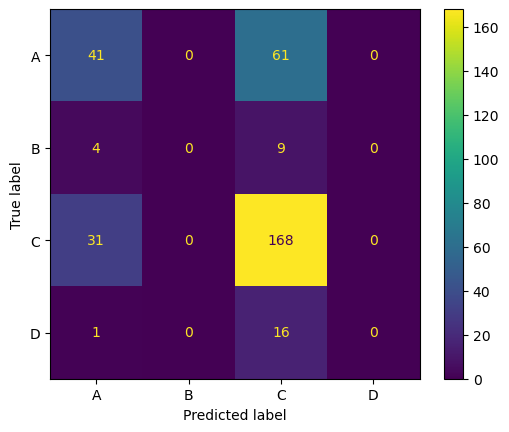

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=classification.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classification.classes_)
disp.plot()

plt.show()

In [34]:
np.diag(cm).sum()

209

In [35]:
cm.sum()

331

In [36]:
np.diag(cm).sum() / cm.sum()

0.6314199395770392

In [37]:
from sklearn.preprocessing import StandardScaler
churnData = pd.read_csv('customer_churn.csv')
churnData.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'customer_churn.csv'

In [ ]:
churnData['Churn'].value_counts()
# As you can see there is a huge imbalance in the representation of the two categories

In [ ]:
numericData = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
Y = pd.DataFrame(data=churnData, columns=['Churn'])
transformer = StandardScaler().fit(churnData[['tenure','SeniorCitizen','MonthlyCharges']])
scaled_x = transformer.transform(churnData[['tenure','SeniorCitizen','MonthlyCharges']])
classification = LogisticRegression().fit(scaled_x, churnData['Churn'])
classification.score(scaled_x, churnData['Churn'])

In [ ]:
yes = churnData[churnData['Churn']=='Yes']
no = churnData[churnData['Churn']=='No']
yes = yes.sample(500)

In [ ]:
data = pd.concat([yes,no], axis=0)
print(data['Churn'].value_counts())
data.head()

In [ ]:
numericData = data[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(data[['tenure','SeniorCitizen','MonthlyCharges']])
scaled_x = transformer.transform(data[['tenure','SeniorCitizen','MonthlyCharges']])
classification = LogisticRegression().fit(scaled_x, data['Churn'])
classification.score(scaled_x, data['Churn'])

In [ ]:
counts = churnData['Churn'].value_counts()
counts = counts[0]

In [ ]:
yes = churnData[churnData['Churn']=='Yes'].sample(counts, replace=True)

In [ ]:
no = churnData[churnData['Churn']=='No']
data = pd.concat([yes,no], axis=0)


In [ ]:
data['Churn'].value_counts()

In [ ]:
X = data[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X, data['Churn'])
classification.score(X, data['Churn'])

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Undersampling

rus = RandomUnderSampler()
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
y = churnData['Churn']
X_rus, y_rus = rus.fit_resample(X, y)

In [ ]:
y.value_counts()

In [ ]:
y_rus.value_counts()

In [ ]:
transformer = StandardScaler().fit(X_rus)
X = transformer.transform(X_rus)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X, y_rus)
classification.score(X, y_rus)

In [ ]:
# oversampling 
ros = RandomOverSampler()
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
y = churnData['Churn']
X_ros, y_ros = ros.fit_resample(X, y)


In [ ]:
y.value_counts()

In [ ]:
y_ros.value_counts()

In [ ]:
transformer = StandardScaler().fit(X_ros)
X = transformer.transform(X_ros)
classification = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='ovr').fit(X, y_ros)
classification.score(X, y_ros)

In [ ]:
# Synethetic Minority Oversampling Technique (SMOTE)

from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = churnData[['tenure', 'SeniorCitizen','MonthlyCharges']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
y = churnData['Churn']
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()